# Compare models for Segmentation

## Functions

In [7]:
import sys, site
print("exe:", sys.executable)
print("version:", sys.version)
print("site:", site.getsitepackages()[:2])


exe: /home/ads4015/.conda/envs/monai-env1/bin/python
version: 3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]
site: ['/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages']


In [8]:
"""
SELMA3D segmentation metrics and plots for multiple models
(including microSAM finetuned cross‑val results).

Metrics per patch:
- total_dice      : average of foreground and background Dice
- foreground_dice : Dice on foreground voxels only (union of pred/GT foreground)
- instances_pred  : # of connected components in prediction
- instances_gt    : # of connected components in GT

Final summary tables / plots:
- Per‑file metrics table
- Fold‑level and train‑size‑level summaries
- Tables and plots vs train size (ntr)

Models:
- autumn  (pretrained model, prob maps)
- expert  (pretrained model, prob maps)
- random  (random init baseline, prob maps)
- microsam (microSAM finetuned models, instance‑label predictions)
"""

# ==========================
# Imports & Config
# ==========================

import os
from pathlib import Path
import re
import tifffile as tiff
import warnings

import nibabel as nib
import numpy as np
import pandas as pd

from scipy.ndimage import label as cc_label


# -------------------
# PATH CONFIGURATION
# -------------------

# Prediction roots (already point at the .../preds folders)
MODEL_ROOTS = {
    "autumn": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_autumn_sweep_27_v2/preds"),
    "autumn_overtrain": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_autumn_sweep_27_long/preds"),
    "expert": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_expert_sweep_31_v2/preds"),
    "random": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_rand_v2/preds"),
    # microSAM finetuned predictions (two variants: b and l)
    "microsam_b": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/micro_sam/finetuned_cross_val_b/preds"),
    "microsam_l": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/micro_sam/finetuned_cross_val_l/preds"),
    "cellseg3d": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/cellseg3d/finetuned_cross_val/preds"),
    # cellpose predictions (2d and 3d)
    "cellpose2d": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/cellpose/cross_val/preds"),
    "cellpose3d": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/cellpose/cross_val/preds"),
    # nnunet
    "nnunet": Path("/midtier/paetzollab/scratch/ads4015/compare_methods/nnunet/cross_val/preds")
}

# Ground‑truth root
GT_ROOT = Path("/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches")
NNUNET_GT_ROOT = Path("/midtier/paetzollab/scratch/ads4015/compare_methods/nnunet/cross_val/raw")

# Datatype <-> GT folder mapping
DATA_TYPES = ["amyloid_plaque", "c_fos_positive", "cell_nucleus", "vessels"]

DATA_TYPE_TO_GT_SUBDIR = {
    "amyloid_plaque": "amyloid_plaque_patches",
    "c_fos_positive": "c_fos_positive_patches",
    "cell_nucleus": "cell_nucleus_patches",
    "vessels": "vessels_patches",
}

# Define output directory
OUTPUT_DIR = Path("/midtier/paetzollab/scratch/ads4015/segmentation_results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Threshold on probability map to get binary prediction
PROB_THRESHOLD = 0.5

# Connectivity structure for 3D connected components (26‑connectivity)
STRUCT_3D_26 = np.ones((3, 3, 3), dtype=bool)

# nnunet mapping for datatypes

# helper function to normalize registry datatype
def normalize_registry_datatype(dt):
    if dt.endswith("_patches"):
        return dt.replace("_patches", "")
    return dt

NNUNET_DATASET_REGISTRY = pd.read_csv(
    "/midtier/paetzollab/scratch/ads4015/compare_methods/nnunet/cross_val/dataset_registry.csv"
)
NNUNET_DATASET_ID_TO_TYPE = {row["dataset_id"]: normalize_registry_datatype(row["datatype"])
                             for _, row in NNUNET_DATASET_REGISTRY.iterrows()}

# nnunet mapping for number of training samples per dataset
NNUNET_DATASET_ID_TO_NUM_TRAIN = {
    int(row["dataset_id"]): int(row["num_train"])
    for _, row in NNUNET_DATASET_REGISTRY.iterrows()
}


# =======================================
# Utility: NIfTI Loader & Filename Parsing
# =======================================

def load_nifti(path: Path) -> np.ndarray:
    """Load a NIfTI file and return a float32 numpy array."""
    img = nib.load(str(path))
    arr = img.get_fdata(dtype=np.float32)
    return arr


# Regex for prediction filename patterns
# Example (pretrained models):
#   patch_003_vol016_ch0_prob_cvfold2_ntr12_nev2_fttr10_ftval2_fold2_trlim12_seed100.nii.gz
PRED_NAME_RE = re.compile(r"^patch_(\d+)_vol(\d+)_ch(\d+)_prob_.*\.nii\.gz$")

# Example (microSAM-b preds, old format):
#   patch_005_vol001_ch0.nii_pred_cvfold0_pool3_ntr2_nval1_ntest2_seed100.nii.gz
PRED_NAME_RE_MICROSAM_B = re.compile(
    r"^patch_(\d+)_vol(\d+)_ch(\d+)\.nii_pred_.*\.nii\.gz$"
)

# Example (microSAM-l preds, new format):
#   patch_007_vol005_ch0_pred_cvfold0_ntr2_nev2_fttr1_ftval1_fold0_trlim2_seed100.nii.gz
PRED_NAME_RE_MICROSAM_L = re.compile(
    r"^patch_(\d+)_vol(\d+)_ch(\d+)_pred_.*\.nii\.gz$"
)

# Cellseg3d TIFF predictions:
#   patch_003_vol016_ch0_instances.tif
PRED_STEM_RE_CELLSEG3D = re.compile(r"^patch_(\d+)_vol(\d+)_ch(\d+)_instances$")

# Example (cellpose preds, 2d and 3d):
#   patch_003_vol016_ch0_pred2d_cvfold0_ntr2_nev2_fttr1_ftval1_fold0_trlim2_seed100.nii.gz
#   patch_005_vol001_ch0_pred3d_cvfold0_ntr2_nev2_fttr1_ftval1_fold0_trlim2_seed100.nii.gz
PRED_NAME_RE_CELLPOSE = re.compile(
    r"^patch_(\d+)_vol(\d+)_pred(2d|3d)_.*\.nii\.gz$"
)

# nnunet predictions
#   Example: case_patch_012_vol033_ch0.nii.gz
PRED_NAME_RE_NNUNET = re.compile(r"^case_patch_(\d+)_vol(\d+)_ch(\d+)\.nii\.gz$")



def parse_pred_name(pred_path: Path, model_name: str):
    """Parse patch_id, vol_id, channel_id from a prediction filename."""

    if model_name == "microsam_b":
        m = PRED_NAME_RE_MICROSAM_B.match(pred_path.name)
        if m:
            return m.group(1), m.group(2), m.group(3)

    elif model_name == "microsam_l":
        m = PRED_NAME_RE_MICROSAM_L.match(pred_path.name)
        if m:
            return m.group(1), m.group(2), m.group(3)

    elif model_name == "cellseg3d":
        m = PRED_STEM_RE_CELLSEG3D.match(pred_path.stem)
        if m:
            return m.group(1), m.group(2), m.group(3)

    elif model_name in ["cellpose2d", "cellpose3d"]:
        m = PRED_NAME_RE_CELLPOSE.match(pred_path.name)
        if not m:
            raise ValueError(f"Cannot parse cellpose filename: {pred_path}")

        patch_id, vol_id, mode = m.groups()
        
        # Cellpose outputs have no channel — assume ch_id = "0"
        ch_id = "0"

        # enforce correct mode
        if model_name == "cellpose2d" and mode != "2d":
            raise ValueError(f"Expected 2D pred, found 3D: {pred_path}")
        if model_name == "cellpose3d" and mode != "3d":
            raise ValueError(f"Expected 3D pred, found 2D: {pred_path}")

        return patch_id, vol_id, ch_id
    
    elif model_name == "nnunet":
        m = PRED_NAME_RE_NNUNET.match(pred_path.name)
        if not m:
            raise ValueError(f"Cannot parse nnunet filename: {pred_path}")
        return m.group(1), m.group(2), m.group(3)

    # Default models: autumn / expert / random
    m = PRED_NAME_RE.match(pred_path.name)
    if m:
        return m.group(1), m.group(2), m.group(3)

    # No match
    raise ValueError(f"Cannot parse prediction filename for model={model_name}: {pred_path}")



def build_gt_path(data_type: str, patch_id: str, vol_id: str, ch_id: str, model_name: str = None, cvfold_name: str = None) -> Path:
    """Build the ground‑truth label path from metadata."""

    # nnunet gt location is separate from preds
    if model_name == "nnunet":
        dataset_folder = NNUNET_GT_ROOT / cvfold_name / "labelsTs"
        gt_name = f"case_patch_{patch_id}_vol{vol_id}_ch{ch_id}.nii.gz"
        return dataset_folder / gt_name
    
    # other models use standard GT root
    gt_subdir = DATA_TYPE_TO_GT_SUBDIR[data_type]
    gt_folder = GT_ROOT / gt_subdir
    gt_name = f"patch_{patch_id}_vol{vol_id}_ch{ch_id}_label.nii.gz"
    return gt_folder / gt_name


# ======================================
# Dice Metrics (Total & Foreground)
# ======================================

def binary_dice(pred: np.ndarray, gt: np.ndarray, eps: float = 1e-8) -> float:
    """Standard foreground Dice on full volume."""
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    intersection = np.logical_and(pred, gt).sum()
    return (2.0 * intersection + eps) / (pred.sum() + gt.sum() + eps)


def background_dice(pred: np.ndarray, gt: np.ndarray, eps: float = 1e-8) -> float:
    """Dice between background regions."""
    pred_bg = np.logical_not(pred)
    gt_bg = np.logical_not(gt)
    intersection = np.logical_and(pred_bg, gt_bg).sum()
    return (2.0 * intersection + eps) / (pred_bg.sum() + gt_bg.sum() + eps)


def total_dice(pred_bin: np.ndarray, gt_bin: np.ndarray, eps: float = 1e-8) -> float:
    """'Total Dice' = average of foreground and background Dice scores."""
    fg_d = binary_dice(pred_bin, gt_bin, eps=eps)
    bg_d = background_dice(pred_bin, gt_bin, eps=eps)
    return 0.5 * (fg_d + bg_d)


def foreground_dice(pred_bin: np.ndarray, gt_bin: np.ndarray, eps: float = 1e-8) -> float:
    """Foreground Dice computed only on voxels that are foreground in either pred or GT.

    This uses the union of pred/GT foreground voxels as the evaluation region.
    If the union is empty (both masks all‑background), returns 1.0 by convention.
    """
    pred_bin = pred_bin.astype(bool)
    gt_bin = gt_bin.astype(bool)
    fg_union = np.logical_or(pred_bin, gt_bin)
    if fg_union.sum() == 0:
        return 1.0

    pred_f = pred_bin[fg_union]
    gt_f = gt_bin[fg_union]
    intersection = np.logical_and(pred_f, gt_f).sum()
    return (2.0 * intersection + eps) / (pred_f.sum() + gt_f.sum() + eps)


# ========================================
# Instance Counts (Connected Components)
# ========================================

def count_instances(mask: np.ndarray, structure=STRUCT_3D_26) -> int:
    """Count connected components (instances) in a 3D binary mask."""
    mask = mask.astype(bool)
    if mask.sum() == 0:
        return 0
    labeled, n_components = cc_label(mask, structure=structure)
    return int(n_components)


# =========================================
# Per‑patch Metric Computation
# =========================================

def compute_metrics_for_pair(pred_path: Path, gt_path: Path) -> dict:
    """Compute all metrics for a single prediction/GT pair.

    Returns a flat dict of metric_name -> value.
    """
    if pred_path.suffix == ".tif":
        pred_prob = tiff.imread(str(pred_path)).astype(np.float32)
    else:
        pred_prob = load_nifti(pred_path)
    gt_bin = load_nifti(gt_path)

    # Binarize
    # For pretrained models, pred_prob is a probability map.
    # For microSAM, pred_prob is an instance‑label map; thresholding at 0.5
    # turns all nonzero labels into foreground.
    pred_bin = pred_prob >= PROB_THRESHOLD
    gt_bin = gt_bin > 0.5  # GT should already be 0/1, but this is safe

    if pred_bin.shape != gt_bin.shape:
        raise ValueError(
            f"Shape mismatch: pred {pred_bin.shape}, gt {gt_bin.shape} for {pred_path} vs {gt_path}"
        )

    # Dice metrics
    td = total_dice(pred_bin, gt_bin)
    fd = foreground_dice(pred_bin, gt_bin)

    # Instance counts
    n_inst_pred = count_instances(pred_bin)
    n_inst_gt = count_instances(gt_bin)

    # Instance Dice based on counts (scalar Dice on instance numbers)
    if n_inst_pred == 0 and n_inst_gt == 0:
        inst_dice = 1.0
    else:
        inst_dice = (2.0 * min(n_inst_pred, n_inst_gt)) / float(n_inst_pred + n_inst_gt)

    metrics = {
        "total_dice": td,
        "foreground_dice": fd,
        "instance_dice": inst_dice,
        "instances_pred": n_inst_pred,
        "instances_gt": n_inst_gt,
    }

    return metrics


# ==================================================
# Discovery & Loop Over All Models / Types
# ==================================================

def discover_pred_files(model_name: str, model_root: Path, data_type: str):
    """Discover all prediction files for a given model root and data_type.

    Returns a list of (pred_path, cvfold_name).
    """

    # === Special case: CellSeg3D only has predictions for cell_nucleus ===
    if model_name == "cellseg3d" and data_type != "cell_nucleus":
        return []

    results = []

    # ----------------------------
    # microSAM directory structure(s)
    # ----------------------------
    if model_name.startswith("microsam"):
        # For microSAM, data_type is the short name (e.g. "amyloid_plaque"),
        # and DATA_TYPE_TO_GT_SUBDIR gives the full folder (e.g. "amyloid_plaque_patches").
        type_root = model_root / DATA_TYPE_TO_GT_SUBDIR[data_type]
        if not type_root.is_dir():
            warnings.warn(f"{type_root} does not exist for {model_name}; skipping.")
            return results

        # microsam_b: old format, e.g. fold_cv0_pool3_ntr2_nval1_ntest2/patches
        # microsam_l: new format, e.g. cvfold0_ntr2_nev2_fttr1_ftval1_fold0_trlim2_seed100/patches
        for fold_dir in sorted(type_root.iterdir()):
            if not fold_dir.is_dir():
                continue

            if model_name == "microsam_b":
                if not fold_dir.name.startswith("fold_cv"):
                    continue
            elif model_name == "microsam_l":
                if not fold_dir.name.startswith("cvfold"):
                    continue

            cvfold_name = fold_dir.name
            preds_dir = fold_dir / "patches"
            if not preds_dir.is_dir():
                warnings.warn(f"No patches/ directory in {fold_dir}; skipping.")
                continue

            for pred_path in sorted(preds_dir.glob("patch_*.nii.gz")):
                results.append((pred_path, cvfold_name))

        return results
    
    # ----------------------------
    # CellSeg3D TIFF predictions
    # ----------------------------
    if model_name == "cellseg3d":
        type_root = model_root / DATA_TYPE_TO_GT_SUBDIR[data_type] # CellSeg3D uses the same folder naming as GT root (e.g., cell_nucleus_patches)
        if not type_root.is_dir():
            warnings.warn(f"{type_root} missing for CellSeg3D; skipping.")
            return []

        results = []
        for fold_dir in sorted(type_root.iterdir()):
            if not fold_dir.is_dir():
                continue
            if not fold_dir.name.startswith("cvfold"):
                continue
            cvfold_name = fold_dir.name
            preds_dir = fold_dir

            # Use instances outputs only
            for pred_path in sorted(preds_dir.glob("*_instances.tif")):
                results.append((pred_path, cvfold_name))

        return results
    

    # ----------------------------------------
    # Cellpose-SAM finetuned (two variants)
    # ----------------------------------------
    if model_name in ["cellpose2d", "cellpose3d"]:
        # Only exists for cell_nucleus
        if data_type != "cell_nucleus":
            return []

        type_root = model_root / "cell_nucleus_patches"
        if not type_root.is_dir():
            warnings.warn(f"{type_root} missing for Cellpose; skipping.")
            return []

        results = []
        for fold_dir in sorted(type_root.iterdir()):
            if not fold_dir.is_dir():
                continue
            if not fold_dir.name.startswith("cvfold"):
                continue

            cvfold_name = fold_dir.name

            # Matches both pred2d_* and pred3d_* files
            for pred_path in sorted(fold_dir.glob("patch_*_pred*.nii.gz")):
                # Check file type matches the model:
                if model_name == "cellpose2d" and "_pred2d_" not in pred_path.name:
                    continue
                if model_name == "cellpose3d" and "_pred3d_" not in pred_path.name:
                    continue

                results.append((pred_path, cvfold_name))

        return results

    # ----------------------------------------
    # nnunet
    # ----------------------------------------
    if model_name == "nnunet":
        results = []

        for dataset_dir in sorted(model_root.glob("Dataset*")):
            if not dataset_dir.is_dir():
                continue

            cvfold_name = dataset_dir.name # ex: Dataset1000
            dataset_id_str = cvfold_name.replace("Dataset", "") # id is the number only
            dataset_id = int(dataset_id_str)

            # determine datatype from registry
            if dataset_id not in NNUNET_DATASET_ID_TO_TYPE:
                warnings.warn(f"Dataset ID {dataset_id} not found in nnunet registry; skipping.")
                continue

            data_type_for_dataset = NNUNET_DATASET_ID_TO_TYPE[dataset_id]

            # only return preds for correct datatype
            if data_type_for_dataset != data_type:
                continue

            for pred_path in sorted(dataset_dir.glob("case_patch_*_vol*_ch*.nii.gz")):
                results.append((pred_path, cvfold_name))

        return results
    

    # -------------------------------------------
    # Original structure for autumn/expert/random
    # -------------------------------------------
    type_root = model_root / data_type
    if not type_root.is_dir():
        warnings.warn(f"{type_root} does not exist; skipping.")
        return results

    # cvfold directories like: cvfold0_ntr3_nev2_fttr2_ftval1_fold0_trlim3_seed100
    for fold_dir in sorted(type_root.iterdir()):
        if not fold_dir.is_dir():
            continue
        if not fold_dir.name.startswith("cvfold"):
            continue

        cvfold_name = fold_dir.name  # keep full string
        preds_dir = fold_dir / "preds"
        if not preds_dir.is_dir():
            warnings.warn(f"No preds/ directory in {fold_dir}; skipping.")
            continue

        for pred_path in sorted(preds_dir.glob("*_prob_*.nii.gz")):
            # Only use raw probability maps; skip thresholded *_pred_* files
            results.append((pred_path, cvfold_name))

    return results


def collect_all_metrics():
    """Iterate over models, data types, CV folds, and compute per‑file metrics.
    Returns a pandas DataFrame with one row per prediction file.
    """
    rows = []

    for model_name, model_root in MODEL_ROOTS.items():
        print(f"\n[INFO] Processing model: {model_name} ({model_root})")

        for data_type in DATA_TYPES:
            print(f"  - data_type: {data_type}")
            pred_items = discover_pred_files(model_name, model_root, data_type)

            for pred_path, cvfold_name in pred_items:
                try:
                    patch_id, vol_id, ch_id = parse_pred_name(pred_path, model_name)
                except ValueError as e:
                    warnings.warn(str(e))
                    continue

                gt_path = build_gt_path(data_type=data_type, 
                                        patch_id=patch_id, 
                                        vol_id=vol_id, 
                                        ch_id=ch_id,
                                        model_name=model_name,
                                        cvfold_name=cvfold_name
                                        )

                if not gt_path.is_file():
                    warnings.warn(f"GT not found for {pred_path}: {gt_path}")
                    continue

                try:
                    metrics = compute_metrics_for_pair(pred_path, gt_path)
                except Exception as e:
                    warnings.warn(f"Failed metrics for {pred_path} vs {gt_path}: {e}")
                    continue

                # cvfold_id is a coarse identifier (e.g. 'cvfold0' or 'fold_cv0')
                parts = cvfold_name.split("_")
                if len(parts) >= 2 and parts[0] == "fold" and parts[1].startswith("cv"):
                    cvfold_id = "_".join(parts[:2])  # e.g. 'fold_cv0'
                else:
                    cvfold_id = parts[0]               # e.g. 'cvfold0'

                row = {
                    "model": model_name,
                    "data_type": data_type,
                    "cvfold": cvfold_name,   # full string
                    "cvfold_id": cvfold_id,
                    "patch_id": patch_id,
                    "vol_id": vol_id,
                    "channel_id": ch_id,
                    "pred_path": str(pred_path),
                    "gt_path": str(gt_path),
                }
                row.update(metrics)
                rows.append(row)

    df = pd.DataFrame(rows)
    return df


# =======================================
# Run collection to get per‑file metrics
# =======================================

metrics_df = collect_all_metrics()
print("\n[INFO] Done. Number of rows:", len(metrics_df))
try:
    display(metrics_df.head())  # works in notebooks
except NameError:
    print(metrics_df.head())


# =======================================
# Extract train size from cvfold name
# =======================================


def extract_train_size_from_row(row):
    """Extract the x-axis 'train_size' from a row.

    For autumn/expert/random and microsam_l:
        use `_ntr<k>_` from cvfold name.

    For microsam_b (old format):
        use `_pool<p>_` from cvfold name.
    """
    cvfold_name = row["cvfold"]
    model_name = row["model"]

    # microsam_b: use pool size if available (microsam-b uses old code formatting)
    if model_name == "microsam_b":
        m_pool = re.search(r"_pool(\d+)_", cvfold_name)
        if m_pool:
            return int(m_pool.group(1))
        # fallback to ntr if pool not found
        m_ntr = re.search(r"_ntr(\d+)_", cvfold_name)
        if m_ntr:
            return int(m_ntr.group(1))
        return np.nan
    
    # special handling for nnunet
    if model_name == "nnunet":
        if cvfold_name.startswith("Dataset"):
            dataset_id = int(cvfold_name.replace("Dataset", ""))
            if dataset_id in NNUNET_DATASET_ID_TO_NUM_TRAIN:
                return NNUNET_DATASET_ID_TO_NUM_TRAIN[dataset_id]
        return np.nan

    # autumn / expert / random / microsam_l: standard ntr
    m_ntr = re.search(r"_ntr(\d+)_", cvfold_name)
    if m_ntr:
        return int(m_ntr.group(1))
    return np.nan


metrics_df["train_size"] = metrics_df.apply(extract_train_size_from_row, axis=1)

print("[INFO] Unique train sizes found:", sorted(metrics_df["train_size"].dropna().unique()))
try:
    display(metrics_df.head())
except NameError:
    print(metrics_df.head())


# ==========================================================
# Fold-level summary (per train size / cvfold)
# ==========================================================

# Metrics to aggregate
metric_columns = [
    "total_dice",
    "foreground_dice",
    "instance_dice",
    "instances_pred",
    "instances_gt",
]

# Keep only existing columns
metric_columns = [c for c in metric_columns if c in metrics_df.columns]

# We average over files *within* a cvfold directory (e.g., 2 outputs per fold),
# but keep each cvfold/train_size separate.
summary_by_model_type_fold = (
    metrics_df
    .groupby(["model", "data_type", "cvfold", "train_size"])[metric_columns]
    .mean()
    .reset_index()
    .sort_values(["data_type", "model", "train_size", "cvfold"])
)

print("[INFO] Fold-level summary (one row per (model, data_type, cvfold, train_size)):")
try:
    display(summary_by_model_type_fold.head())
except NameError:
    print(summary_by_model_type_fold.head())

summary_fold_csv_path = OUTPUT_DIR / "summary_by_model_type_and_fold_train_size.csv"
summary_by_model_type_fold.to_csv(summary_fold_csv_path, index=False)
print("Fold-level summary saved to:", summary_fold_csv_path)


# ==========================================================
# Train-size summary (averaged over folds)
# ==========================================================

# For each (model, data_type, train_size), average metrics over all
# folds that share the same train_size. This is what we will use for
# the tables and plots.
summary_by_model_type_train = (
    summary_by_model_type_fold
    .groupby(["model", "data_type", "train_size"])[metric_columns]
    .mean()
    .reset_index()
    .sort_values(["data_type", "model", "train_size"])
)

train_summary_csv_path = OUTPUT_DIR / "summary_by_model_type_and_train_size.csv"
summary_by_model_type_train.to_csv(train_summary_csv_path, index=False)
print("Train-size-averaged summary saved to:", train_summary_csv_path)


# ======================================
# Save Raw Metrics to CSV
# ======================================

raw_csv_path = OUTPUT_DIR / "selma3d_segmentation_metrics_per_file.csv"
metrics_df.to_csv(raw_csv_path, index=False)
print("Raw per-file metrics saved to:", raw_csv_path)


# ==========================================================
# Summary: Averages over files (all CV folds)
# ==========================================================

metric_columns = [
    "total_dice",
    "foreground_dice",
    "instances_pred",
    "instances_gt",
]


# Keep only existing columns
metric_columns = [c for c in metric_columns if c in metrics_df.columns]

summary_by_model_type = (
    metrics_df
    .groupby(["model", "data_type"])[metric_columns]
    .mean()
    .reset_index()
)

print("\n[INFO] Summary: Averages of each score over all files")
try:
    display(summary_by_model_type)
except NameError:
    print(summary_by_model_type)

summary_csv_path = OUTPUT_DIR / "summary_by_model_and_type_means.csv"
summary_by_model_type.to_csv(summary_csv_path, index=False)
print("Summary (by model & type) saved to:", summary_csv_path)


# ==========================================================
# Optional: two-stage summary with fold-level means
# ==========================================================

fold_means = (
    metrics_df
    .groupby(["model", "data_type", "cvfold_id"])[metric_columns]
    .mean()
    .reset_index()
)

summary_two_stage = (
    fold_means
    .groupby(["model", "data_type"])[metric_columns]
    .mean()
    .reset_index()
)

summary_two_stage_csv = OUTPUT_DIR / "summary_by_model_and_type_two_stage_means.csv"
summary_two_stage.to_csv(summary_two_stage_csv, index=False)
print("Two-stage fold-then-model means saved to:", summary_two_stage_csv)


# ================================
# Tables & Plots vs Train Size
# ================================

import matplotlib.pyplot as plt

# Choose which metrics to visualize in plots
PLOT_METRICS = ["total_dice", "foreground_dice", "instance_dice"]

# Pretty names, colors, and markers for each model in tables/plots
MODEL_DISPLAY = {
    "autumn": "Image+CLIP",
    "autumn_overtrain": "Image+CLIP (Overtrain)",
    "expert": "Image-only",
    "random": "Random init",
    "microsam_b": "microSAM-B",
    "microsam_l": "microSAM-L",
    "cellseg3d": "CellSeg3D",
    "cellpose2d": "Cellpose-SAM (2D)",
    "cellpose3d": "Cellpose-SAM (3D)",
    "nnunet": "nnU-Net",
}

MODEL_ORDER = [
    "autumn",  # Image+CLIP
    "autumn_overtrain", # Image+CLIP (Overtrain)
    "expert", # Image-only
    "random", # Random init
    "microsam_b", # microSAM base
    "microsam_l", # microSAM large
    "cellseg3d", # CellSeg3D
    "cellpose2d", # Cellpose-SAM (2D)
    "cellpose3d", # Cellpose-SAM (3D)
    "nnunet",    # nnU-Net
]

MODEL_COLOR = {
    "autumn": "cornflowerblue",   # Image+CLIP
    "autumn_overtrain": "mediumblue", # Image+CLIP (Overtrain)
    "expert": "mediumseagreen",   # Image-only
    "random": "lightcoral",       # Random init
    "microsam_b": "orange",       # microSAM-B
    "microsam_l": "peru",         # microSAM-L (L model)
    "cellseg3d": "mediumorchid",        # CellSeg3D
    "cellpose2d": "silver",         # Cellpose-SAM (2D)
    "cellpose3d": "dimgray",           # Cellpose-SAM (3D)
    "nnunet": "darkkhaki",              # nnU-Net
}

MODEL_MARKER = {
    "autumn": "o",   # dots
    "autumn_overtrain": "o", # dots
    "expert": "s",   # squares
    "random": "X",   # x's
    "microsam_b": "^", # triangles
    "microsam_l": "^", # triangles
    "cellseg3d": "D", # diamonds
    "cellpose2d": "P", # plus signs
    "cellpose3d": "P", # plus signs
    "nnunet": "p",    # pentagons
}


# 1) Pretty table view for each data_type

def show_summary_table_for_type(data_type: str, show_models=None):
    df_dt = summary_by_model_type_train[
        summary_by_model_type_train["data_type"] == data_type
    ].copy()
    if df_dt.empty:
        print(f"[WARN] No rows for data_type={data_type}")
        return

    # Sort rows by train size then model so it's easy to read
    df_dt["model"] = pd.Categorical(df_dt["model"], categories=MODEL_ORDER, ordered=True)
    df_dt = df_dt.sort_values(["train_size", "model"])

    # show/hide
    if show_models is not None:
        df_dt = df_dt[df_dt["model"].isin(show_models)]


    # Use pretty display names for the model column in the table
    df_dt["model"] = df_dt["model"].map(MODEL_DISPLAY)

    cols = ["model", "train_size"] + PLOT_METRICS
    table = df_dt[cols]


    try:
        display(table.style.format("{:.4f}", subset=PLOT_METRICS))
    except:
        print(table)


# 2) Line plots: metric vs train_size, one line per model

def plot_metric_vs_train_size_for_type(data_type: str, xlim=None, show_models=None):
    
    # get data for this type
    df_dt = metrics_df[metrics_df["data_type"] == data_type].copy()
    if df_dt.empty:
        print(f"[WARN] No rows for data_type={data_type}")
        return
    
    # sort models in canonical order
    df_dt['model'] = pd.Categorical(df_dt['model'], categories=MODEL_ORDER, ordered=True)
    df_dt = df_dt.sort_values(['train_size', 'model'])

    # default to show all models
    if show_models is None:
        show_models = MODEL_ORDER
    else:
        show_models = [m for m in MODEL_ORDER if m in show_models]

    # prepare global xmin/xmax for clamping
    all_x = sorted(df_dt["train_size"].dropna().unique())
    if xlim is not None:
        xmin, xmax = xlim
    else:
        xmin, xmax = min(all_x), max(all_x)

    # plot each metric
    for metric in PLOT_METRICS:
        if metric not in df_dt.columns:
            continue

        plt.figure(figsize=(7, 5))

        for model in show_models:
            df_m = df_dt[df_dt["model"] == model]
            if df_m.empty:
                continue

            # original arrays
            x_full = df_m["train_size"].values.astype(float)
            y_full = df_m[metric].values.astype(float)

            # clamp points for scatter plot
            mask = (x_full >= xmin) & (x_full <= xmax)
            x = x_full[mask]
            y = y_full[mask]

            if len(x) == 0:
                continue  # no data in range

            # scatter points
            plt.scatter(
                x, y,
                label=MODEL_DISPLAY.get(model, model),
                color=MODEL_COLOR.get(model),
                marker=MODEL_MARKER.get(model, "o"),
                alpha=0.8,
            )

            # fit trend line only on visible points
            if len(np.unique(x)) > 1:
                coef = np.polyfit(x, y, 1)
                poly = np.poly1d(coef)

                xs = np.linspace(xmin, xmax, 200)
                plt.plot(xs, poly(xs), color=MODEL_COLOR.get(model))


        # labels and formatting
        plt.xlabel("Train size")
        plt.ylabel(metric.replace("_", " ").title())
        plt.title(
            f"Segmentation: {metric.replace('_', ' ').title()} vs. Train Size – {data_type.replace('_', ' ').title()}"
        )
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.legend()

        # show integer x ticks
        visible_x = [v for v in all_x if xmin <= v <= xmax]
        plt.xticks(visible_x)

        # apply xlim with padding
        pad = max(1, 0.05 * (xmax - xmin))
        plt.xlim(xmin - pad, xmax + pad)

        plt.tight_layout()
        plt.show()



[INFO] Processing model: autumn (/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_autumn_sweep_27_v2/preds)
  - data_type: amyloid_plaque
  - data_type: c_fos_positive
  - data_type: cell_nucleus
  - data_type: vessels

[INFO] Processing model: autumn_overtrain (/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_autumn_sweep_27_long/preds)
  - data_type: amyloid_plaque
  - data_type: c_fos_positive
  - data_type: cell_nucleus
  - data_type: vessels

[INFO] Processing model: expert (/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_expert_sweep_31_v2/preds)
  - data_type: amyloid_plaque
  - data_type: c_fos_positive
  - data_type: cell_nucleus
  - data_type: vessels

[INFO] Processing model: random (/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_rand_v2/preds)
  - data_type: amyloid_plaque
  - data_type: c_fos_positive
  - data_type: cell_nucleus
  - data_type: vessels

[INFO] Processing model: microsam_b (/midtier/paet

/tmp/ipykernel_3468894/3335170249.py:455: UserWarning: Dataset ID 1252 not found in nnunet registry; skipping.
  warnings.warn(f"Dataset ID {dataset_id} not found in nnunet registry; skipping.")


  - data_type: c_fos_positive
  - data_type: cell_nucleus
  - data_type: vessels

[INFO] Done. Number of rows: 3184


,model,data_type,cvfold,cvfold_id,patch_id,vol_id,channel_id,pred_path,gt_path,total_dice,foreground_dice,instance_dice,instances_pred,instances_gt
0,autumn,amyloid_plaque,cvfold0_ntr10_nev2_fttr8_ftval2_fold0_trlim10_...,cvfold0,007,005,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.494605,0.004194,0.001367,4385,3
1,autumn,amyloid_plaque,cvfold0_ntr10_nev2_fttr8_ftval2_fold0_trlim10_...,cvfold0,018,020,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.477488,0.000287,0.000239,8377,1
2,autumn,amyloid_plaque,cvfold0_ntr11_nev2_fttr9_ftval2_fold0_trlim11_...,cvfold0,007,005,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.688691,0.377570,0.500000,1,3
3,autumn,amyloid_plaque,cvfold0_ntr11_nev2_fttr9_ftval2_fold0_trlim11_...,cvfold0,018,020,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.670949,0.341969,0.400000,4,1
4,autumn,amyloid_plaque,cvfold0_ntr12_nev2_fttr10_ftval2_fold0_trlim12...,cvfold0,007,005,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.657598,0.315412,0.800000,2,3


[INFO] Unique train sizes found: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]


,model,data_type,cvfold,cvfold_id,patch_id,vol_id,channel_id,pred_path,gt_path,total_dice,foreground_dice,instance_dice,instances_pred,instances_gt,train_size
0,autumn,amyloid_plaque,cvfold0_ntr10_nev2_fttr8_ftval2_fold0_trlim10_...,cvfold0,007,005,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.494605,0.004194,0.001367,4385,3,10
1,autumn,amyloid_plaque,cvfold0_ntr10_nev2_fttr8_ftval2_fold0_trlim10_...,cvfold0,018,020,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.477488,0.000287,0.000239,8377,1,10
2,autumn,amyloid_plaque,cvfold0_ntr11_nev2_fttr9_ftval2_fold0_trlim11_...,cvfold0,007,005,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.688691,0.377570,0.500000,1,3,11
3,autumn,amyloid_plaque,cvfold0_ntr11_nev2_fttr9_ftval2_fold0_trlim11_...,cvfold0,018,020,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.670949,0.341969,0.400000,4,1,11
4,autumn,amyloid_plaque,cvfold0_ntr12_nev2_fttr10_ftval2_fold0_trlim12...,cvfold0,007,005,0,/midtier/paetzollab/scratch/ads4015/temp_selma...,/midtier/paetzollab/scratch/ads4015/data_selma...,0.657598,0.315412,0.800000,2,3,12


[INFO] Fold-level summary (one row per (model, data_type, cvfold, train_size)):


,model,data_type,cvfold,train_size,total_dice,foreground_dice,instance_dice,instances_pred,instances_gt
8,autumn,amyloid_plaque,cvfold0_ntr2_nev2_fttr1_ftval1_fold0_trlim2_se...,2,0.616645,0.234918,0.160605,192.0,2.0
24,autumn,amyloid_plaque,cvfold1_ntr2_nev2_fttr1_ftval1_fold1_trlim2_se...,2,0.503364,0.015309,0.012405,3879.5,11.0
40,autumn,amyloid_plaque,cvfold2_ntr2_nev2_fttr1_ftval1_fold2_trlim2_se...,2,0.503836,0.008108,0.029638,249.0,4.0
9,autumn,amyloid_plaque,cvfold0_ntr3_nev2_fttr2_ftval1_fold0_trlim3_se...,3,0.483628,0.002261,0.000758,6107.5,2.0
25,autumn,amyloid_plaque,cvfold1_ntr3_nev2_fttr2_ftval1_fold1_trlim3_se...,3,0.499661,0.000325,0.246803,68.5,11.0


Fold-level summary saved to: /midtier/paetzollab/scratch/ads4015/segmentation_results/summary_by_model_type_and_fold_train_size.csv
Train-size-averaged summary saved to: /midtier/paetzollab/scratch/ads4015/segmentation_results/summary_by_model_type_and_train_size.csv
Raw per-file metrics saved to: /midtier/paetzollab/scratch/ads4015/segmentation_results/selma3d_segmentation_metrics_per_file.csv

[INFO] Summary: Averages of each score over all files


,model,data_type,total_dice,foreground_dice,instances_pred,instances_gt
0,autumn,amyloid_plaque,0.638772,2.835902e-01,1234.802083,5.666667
1,autumn,c_fos_positive,0.762304,5.367184e-01,659.333333,565.833333
2,autumn,cell_nucleus,0.799345,6.115634e-01,245.863636,255.333333
3,autumn,vessels,0.878925,7.798816e-01,49.385965,38.333333
4,autumn_overtrain,amyloid_plaque,0.644455,2.893802e-01,10.033333,5.666667
5,autumn_overtrain,c_fos_positive,0.755258,5.229404e-01,690.500000,565.833333
6,autumn_overtrain,cell_nucleus,0.801318,6.152310e-01,255.772727,255.333333
7,autumn_overtrain,vessels,0.878092,7.781997e-01,51.754902,37.490196
8,cellpose2d,cell_nucleus,0.562873,1.394656e-01,72.265152,258.946970
9,cellpose3d,cell_nucleus,0.793718,5.968019e-01,174.560606,258.946970


Summary (by model & type) saved to: /midtier/paetzollab/scratch/ads4015/segmentation_results/summary_by_model_and_type_means.csv
Two-stage fold-then-model means saved to: /midtier/paetzollab/scratch/ads4015/segmentation_results/summary_by_model_and_type_two_stage_means.csv


## Usage


=== Amyloid Plaque Results ===

*** Table ***


,model,train_size,total_dice,foreground_dice,instance_dice
0,Image+CLIP,2,0.5413,0.0861,0.0675
58,Image+CLIP (Overtrain),2,0.5301,0.0612,0.2793
181,Image-only,2,0.5219,0.0481,0.0342
467,Random init,2,0.5070,0.0209,0.0389
239,microSAM-B,2,0.5410,0.0827,0.2462
315,microSAM-L,2,0.4996,0.0000,0.0526
391,nnU-Net,2,0.7768,0.5542,0.7966
1,Image+CLIP,3,0.4921,0.0011,0.0830
59,Image+CLIP (Overtrain),3,0.5586,0.1177,0.4328
182,Image-only,3,0.5378,0.0786,0.2200



*** Plots (select models) ***


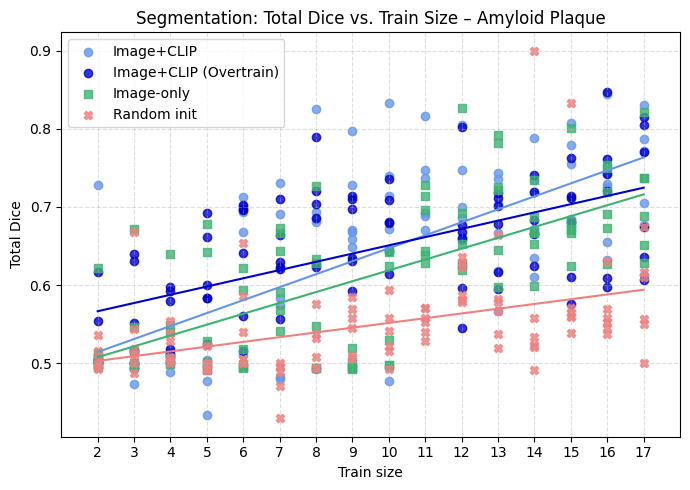

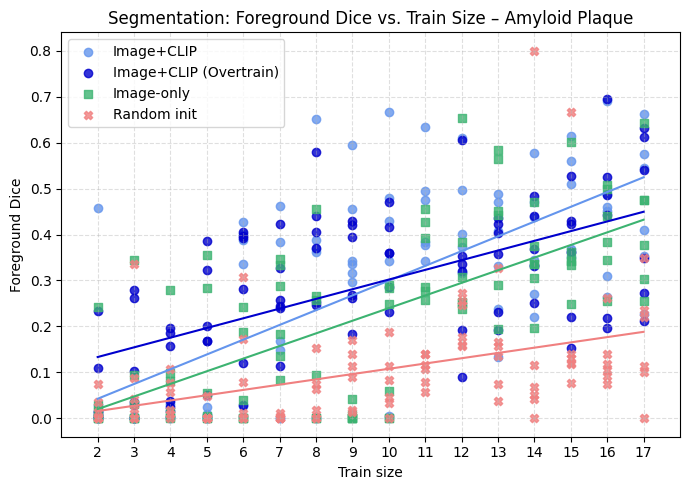

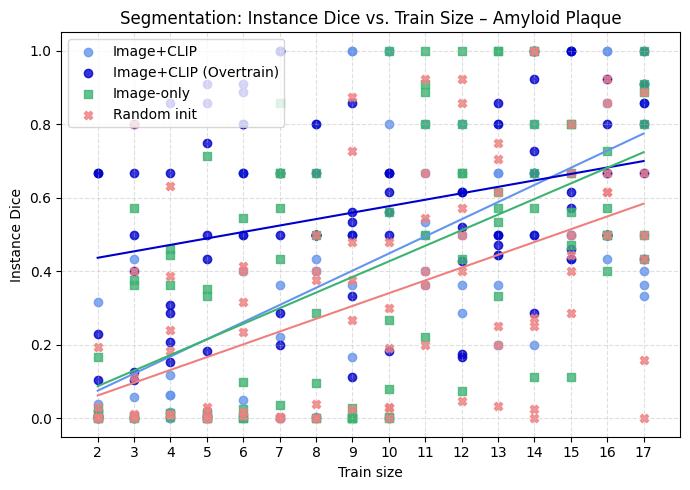


*** Plots (all models) ***


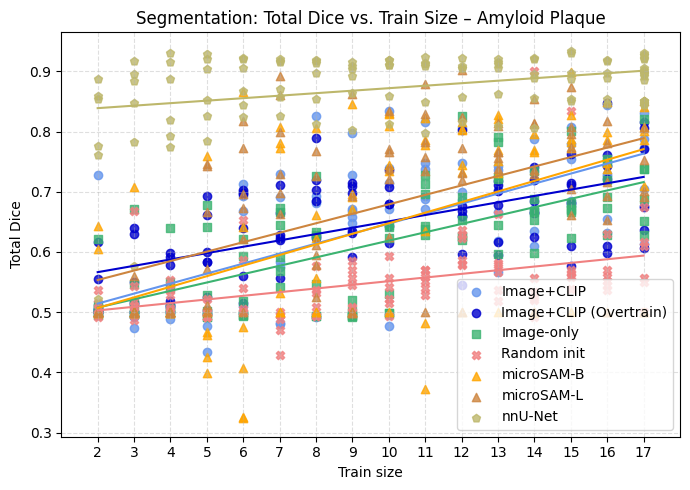

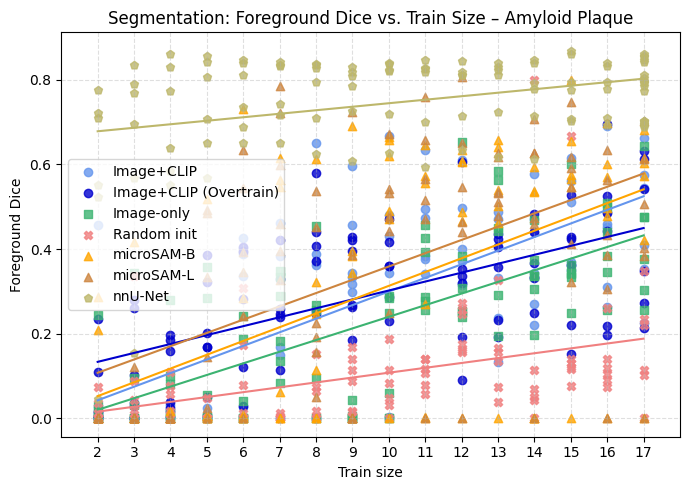

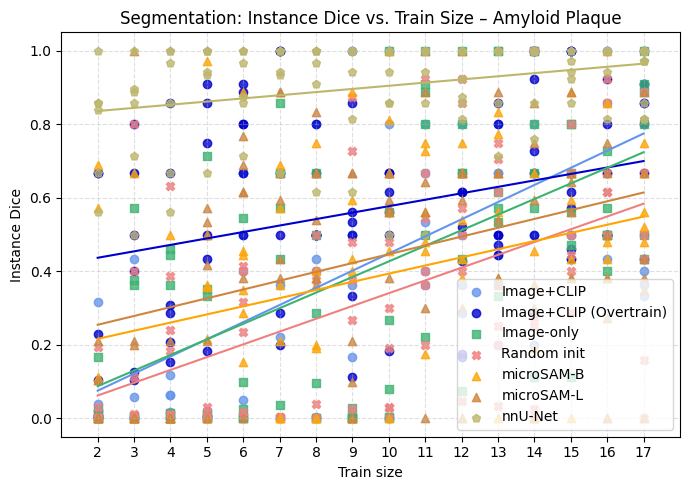

In [9]:
# amyloid plaque
print("\n=== Amyloid Plaque Results ===")
print("\n*** Table ***")
show_summary_table_for_type("amyloid_plaque")
print("\n*** Plots (select models) ***")
plot_metric_vs_train_size_for_type("amyloid_plaque", show_models=["autumn", "autumn_overtrain", "expert", "random"])
print("\n*** Plots (all models) ***")
plot_metric_vs_train_size_for_type("amyloid_plaque")




=== cFos Positive Results ===

*** Table ***


,model,train_size,total_dice,foreground_dice,instance_dice
16,Image+CLIP,2,0.7623,0.5367,0.8602
73,Image+CLIP (Overtrain),2,0.7553,0.5229,0.8336
197,Image-only,2,0.7427,0.5008,0.7731
483,Random init,2,0.6911,0.3992,0.6972
255,microSAM-B,2,0.4952,0.0000,0.0000
331,microSAM-L,2,0.4952,0.0000,0.0000
407,nnU-Net,2,0.8983,0.7999,0.8798



*** Plots (select models) ***


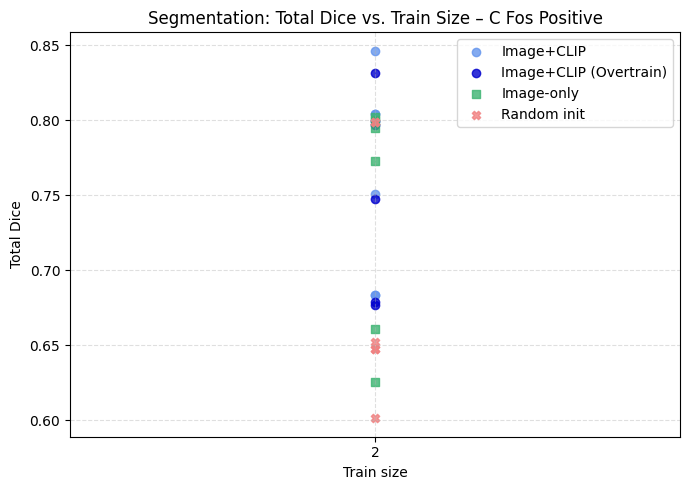

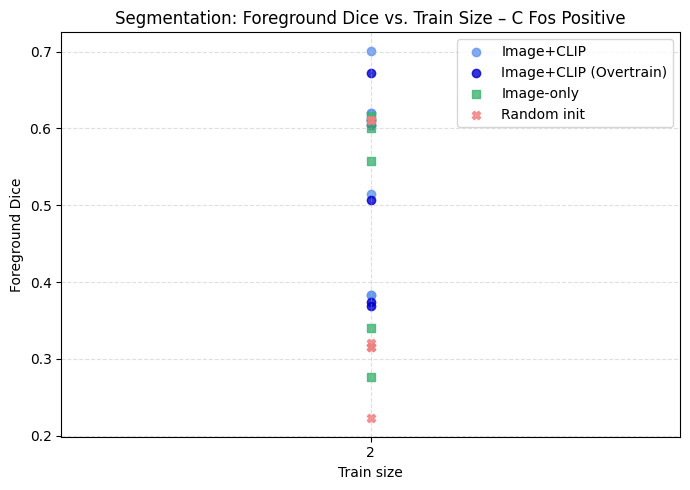

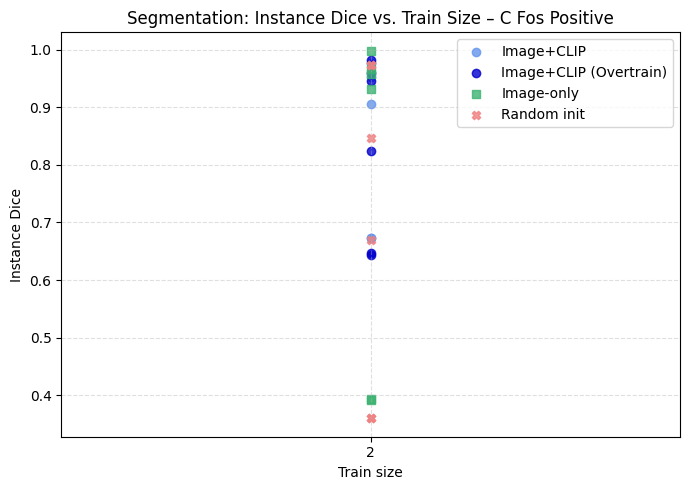


*** Plots (all models) ***


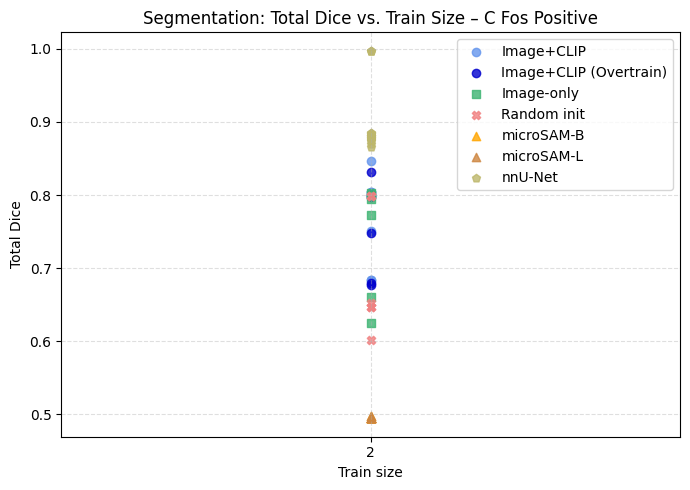

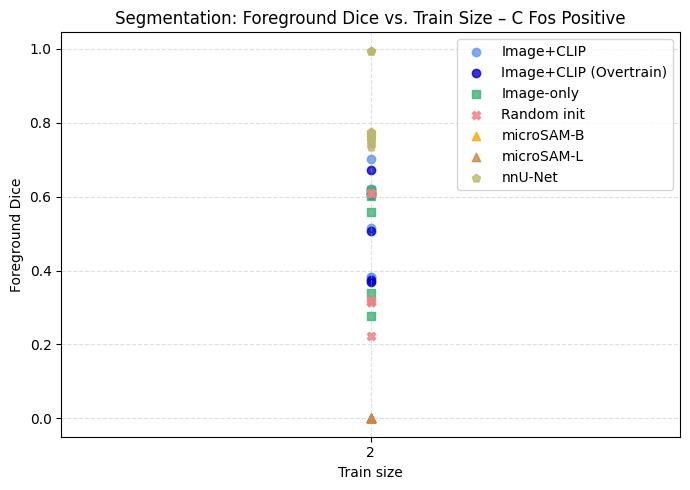

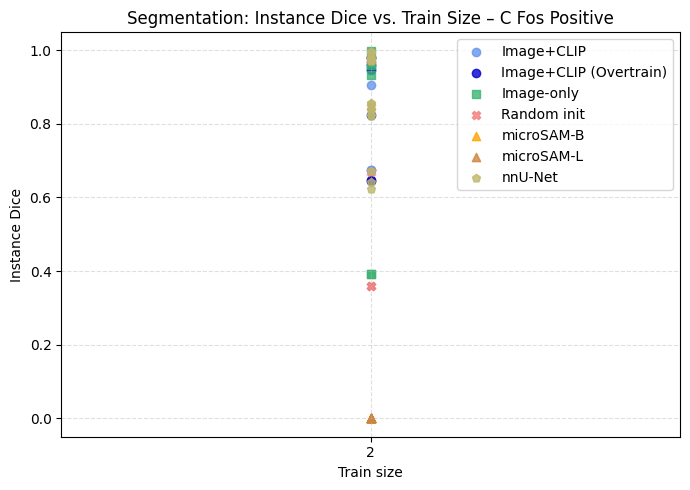

In [10]:
# cfos
print("\n=== cFos Positive Results ===")
print("\n*** Table ***")
show_summary_table_for_type("c_fos_positive")
print("\n*** Plots (select models) ***")
plot_metric_vs_train_size_for_type("c_fos_positive", show_models=["autumn", "autumn_overtrain", "expert", "random"])
print("\n*** Plots (all models) ***")
plot_metric_vs_train_size_for_type("c_fos_positive")




=== Cell Nucleus ===

*** Table ***


,model,train_size,total_dice,foreground_dice,instance_dice
17,Image+CLIP,2,0.7654,0.5460,0.9170
74,Image+CLIP (Overtrain),2,0.7758,0.5654,0.8843
198,Image-only,2,0.7820,0.5796,0.8923
484,Random init,2,0.7699,0.5561,0.9153
256,microSAM-B,2,0.4935,0.0000,0.0000
332,microSAM-L,2,0.4935,0.0000,0.0000
159,CellSeg3D,2,0.5071,0.0384,0.7252
115,Cellpose-SAM (2D),2,0.5955,0.2051,0.5964
137,Cellpose-SAM (3D),2,0.7804,0.5713,0.8167
408,nnU-Net,2,0.8507,0.7093,0.9524



*** Plots (select models) ***


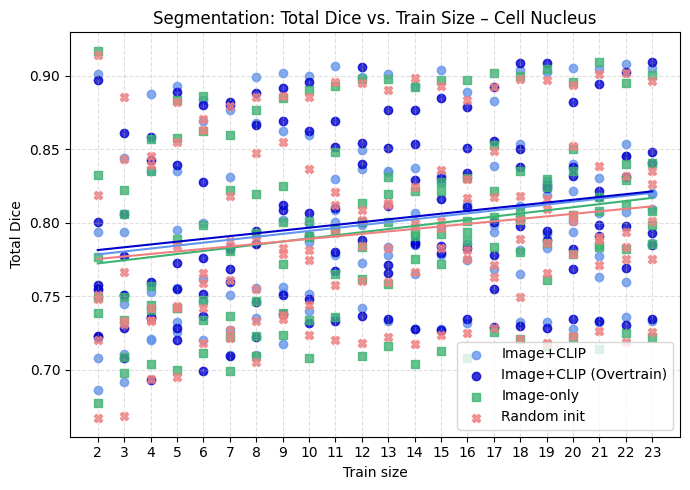

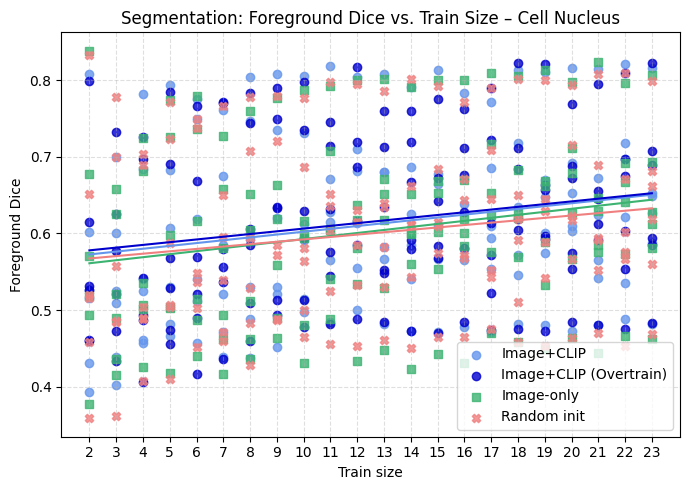

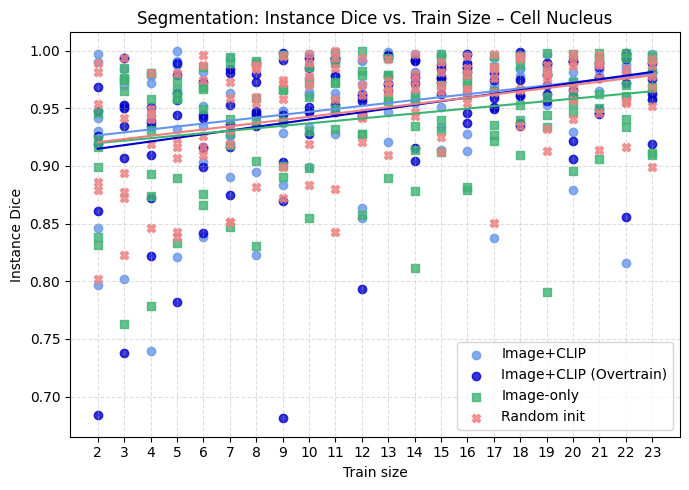


*** Plots (all models) ***


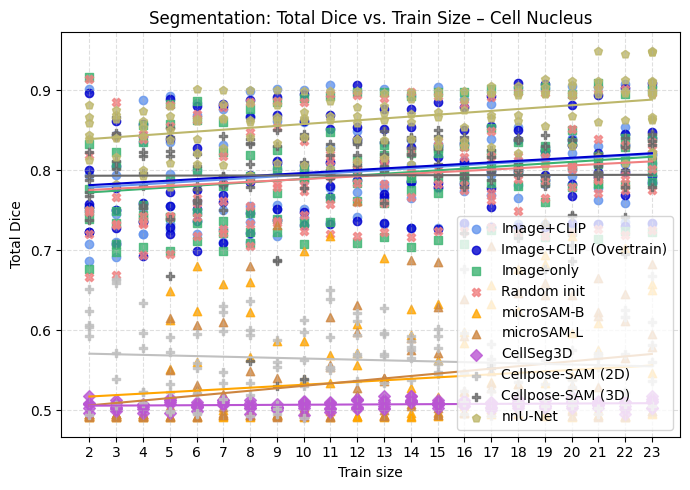

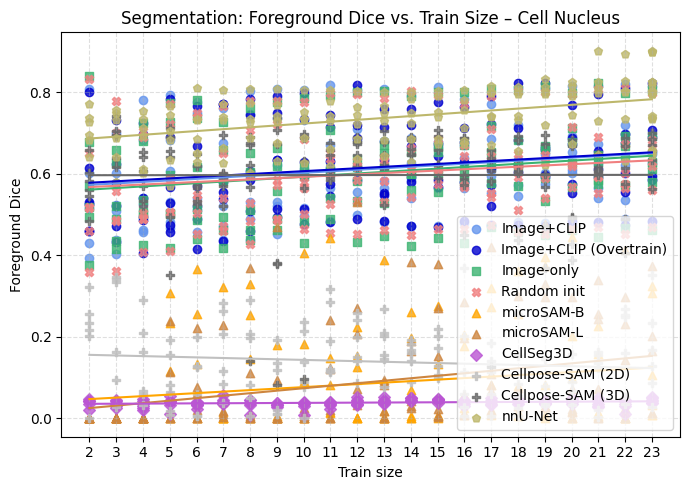

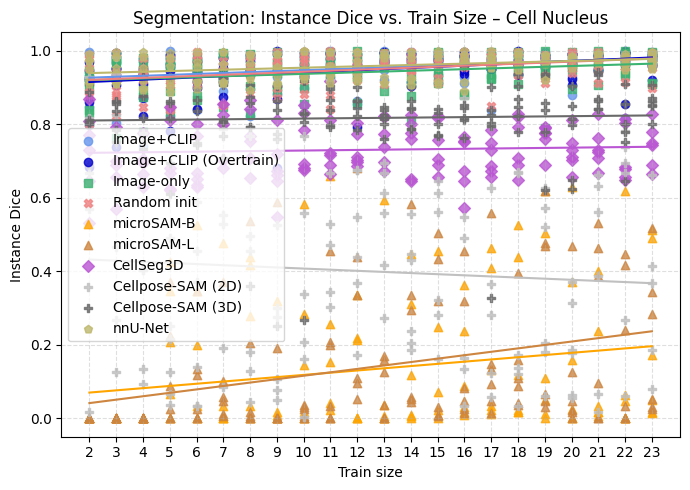

In [11]:
# cell nucleus
print("\n=== Cell Nucleus ===")
print("\n*** Table ***")
show_summary_table_for_type("cell_nucleus")
print("\n*** Plots (select models) ***")
plot_metric_vs_train_size_for_type("cell_nucleus", show_models=["autumn", "autumn_overtrain", "expert", "random"])
print("\n*** Plots (all models) ***")
plot_metric_vs_train_size_for_type("cell_nucleus")




=== Vessels ===

*** Table ***


,model,train_size,total_dice,foreground_dice,instance_dice
39,Image+CLIP,2,0.8218,0.6795,0.8137
96,Image+CLIP (Overtrain),2,0.8252,0.6853,0.7854
220,Image-only,2,0.8035,0.6452,0.6544
506,Random init,2,0.8099,0.6570,0.7184
278,microSAM-B,2,0.6093,0.2592,0.4828
354,microSAM-L,2,0.5109,0.0593,0.3887
430,nnU-Net,2,0.8696,0.7659,0.7134
40,Image+CLIP,3,0.8241,0.6830,0.7235
97,Image+CLIP (Overtrain),3,0.8358,0.7023,0.6827
221,Image-only,3,0.8141,0.6659,0.7617



*** Plots (select models) ***


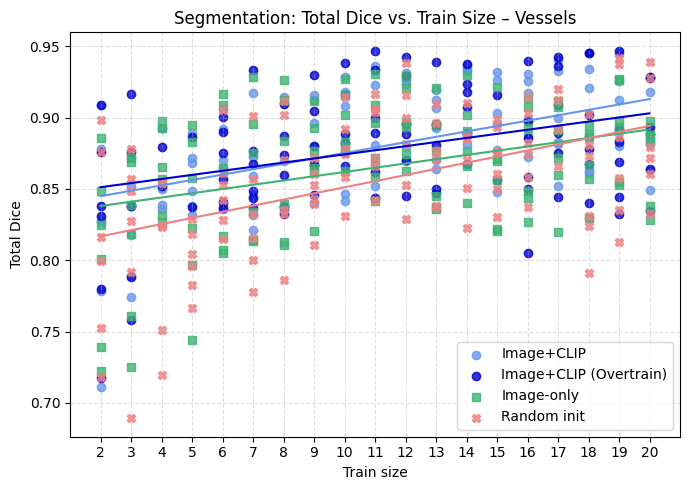

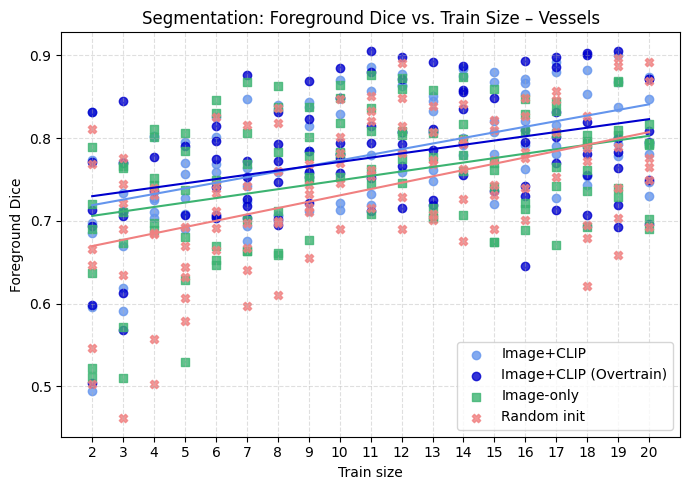

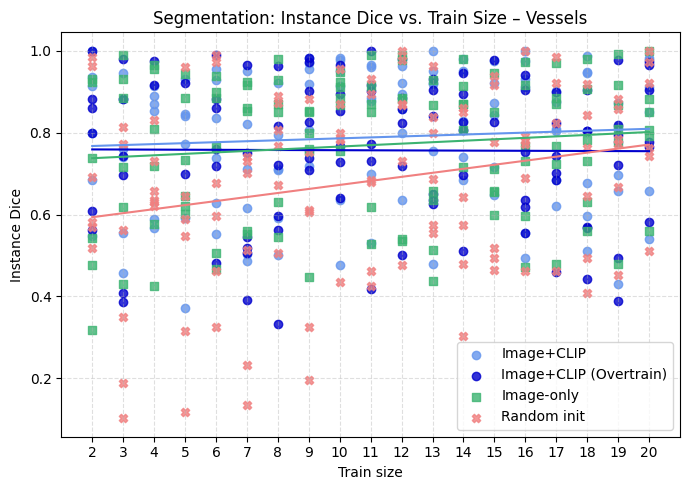


*** Plots (all models) ***


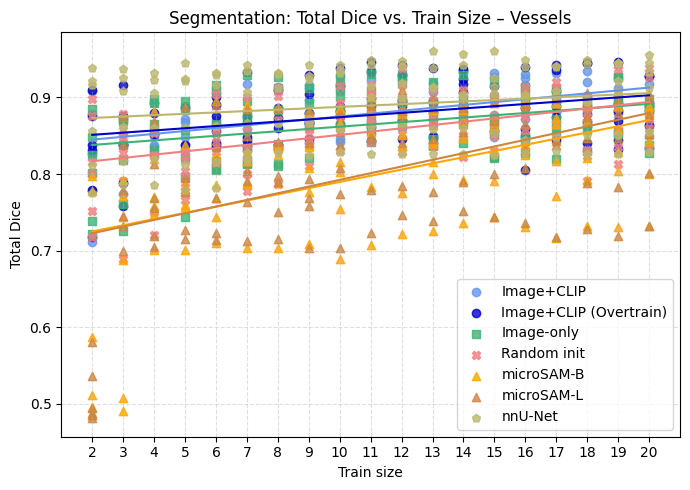

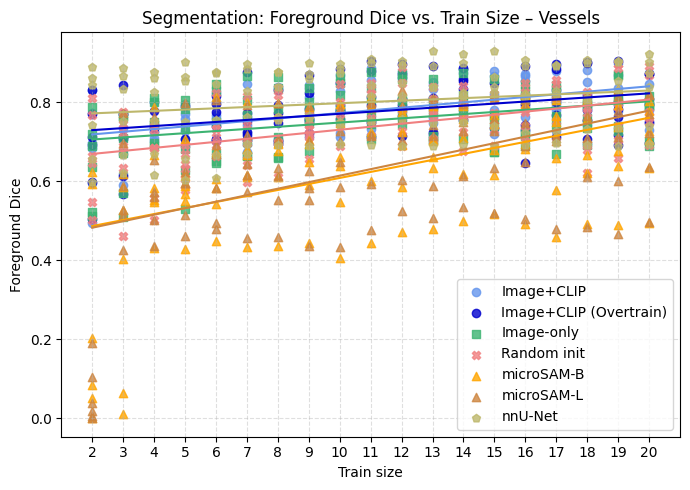

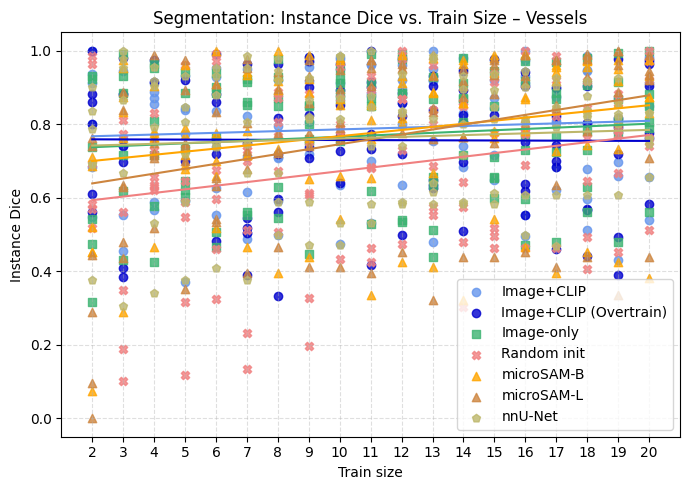

In [12]:
# vessels
print("\n=== Vessels ===")
print("\n*** Table ***")
show_summary_table_for_type("vessels")
print("\n*** Plots (select models) ***")
plot_metric_vs_train_size_for_type("vessels", show_models=["autumn", "autumn_overtrain", "expert", "random"], xlim=(2, 20))
print("\n*** Plots (all models) ***")
plot_metric_vs_train_size_for_type("vessels", xlim=(2, 20))